In [1]:
#!pip install deep-sort-realtime

In [2]:
import time
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from deep_sort_realtime.deepsort_tracker import DeepSort

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import warnings
warnings.filterwarnings("ignore", "You are using `torch.load` with `weights_only=False`*.")

### class names

In [5]:
# COCO class names
COCO_CLASSES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "couch", "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

In [6]:
# COCO class names
COCO_CLASSES_target = [
    "__background__", "person", "bicycle", "car", "motorcycle", "bus", "truck"
]

In [7]:
COCO_CLASSES_filtered = {class_name: COCO_CLASSES.index(class_name) for class_name in COCO_CLASSES_target}
COCO_CLASSES_filtered

{'__background__': 0,
 'person': 1,
 'bicycle': 2,
 'car': 3,
 'motorcycle': 4,
 'bus': 6,
 'truck': 8}

### Load model

In [8]:
# Load Faster R-CNN model
model = fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
    progress=True,
    weights_backbone=ResNet50_Weights.DEFAULT
)

model.eval()  # Set the model to evaluation mode
model = model.to(device)

### Object Detector

In [9]:
# Object Detector
class ObjectDetector:
    def __init__(self, model, classes, device, 
                 confidence_threshold, nms_threshold, resize):
        """
        Initializes the Detector class.
        """
        self.model = model.eval().to(device)
        self.classes = classes
        self.device = device
        self.confidence_threshold = confidence_threshold
        self.nms_threshold = nms_threshold
        self.resize = resize

    def _resize_image(self, image):
        """
        Args:
            image: The input image (PIL Image).
        Returns:
            Resized image (PIL Image).
        """
        if self.resize:
            original_width, original_height = image.size
            min_original_size = float(min(original_width, original_height))
            max_original_size = float(max(original_width, original_height))

            scale = self.resize[0] / min_original_size
            if scale * max_original_size > self.resize[1]:
                scale = self.resize[1] / max_original_size

            new_width = int(original_width * scale)
            new_height = int(original_height * scale)

            image = T.Resize((new_height, new_width))(image)
        return image

    def detect(self, image_path):
        """
        Performs object detection on the input image.
        Args:
            image_path: Path to the image or a PIL Image object.
        """
        # Load and preprocess the image
        if isinstance(image_path, str):
            image = Image.open(image_path).convert("RGB")
        else:
            image = image_path         
        
        image = self._resize_image(image)
        image_tensor = T.ToTensor()(image).to(self.device)

        # Run inference
        with torch.no_grad():
            predictions = self.model([image_tensor])

        boxes = predictions[0]['boxes'].detach().cpu()
        labels = predictions[0]['labels'].detach().cpu()
        scores = predictions[0]['scores'].detach().cpu()

        # Filter predictions by class target
        indices = [i for i, label in enumerate(labels) if label.item() in self.classes.values()]
        boxes = boxes[indices]
        labels = labels[indices]
        scores = scores[indices]

        # Filter by confidence threshold
        mask = scores >= self.confidence_threshold
        boxes = boxes[mask]
        labels = labels[mask]
        scores = scores[mask]

        # Apply Non-Maximum Suppression (NMS)
        nms_indices = torchvision.ops.nms(boxes, scores, iou_threshold=self.nms_threshold)

        # PIL to array
        image_array = np.array(image)
        boxes = boxes[nms_indices].numpy()
        labels = labels[nms_indices].numpy()
        scores = scores[nms_indices].numpy()

        #self._draw_predictions(image_array, boxes, labels, scores)

        return (image_array, boxes, labels, scores)

    def get_class_name(self, label): 
        classes_inverted = {v: k for k, v in self.classes.items()}
        class_name = classes_inverted.get(label, "Unknown")
        
        return class_name

    def _draw_predictions(self, frame, boxes, labels, scores):
        """
        Draws predictions on the video frame.
        """
        for box, label, score in zip(boxes, labels, scores):
            if score > self.confidence_threshold:               
                box = box.astype(np.int32)
                #detector.get_class_name
                class_name = self.get_class_name(label)
                # Draw box
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 1)
                # Add label
                label_text = f'{class_name}: {score:.2f}'
                cv2.putText(frame, label_text, (box[0], box[1] - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

### Single Class Tracker

In [10]:
# SingleClassTracker to support line counting
class SingleClassTracker:
    def __init__(self, detector, target_class, max_age, min_hits, line_counter):
        """
        Initialize single-class tracker with optional line counter
        """
        self.detector = detector
        self.target_class = target_class
        self.tracker = DeepSort(max_age=max_age)
        self.line_counter = line_counter
        self.min_hits = min_hits
        self.max_age = max_age
        
    def track(self, frame):
        """
        Perform object detection and tracking for a specific class
        """
        # Convert frame to numpy array if it's a PIL Image
        if isinstance(frame, Image.Image):
            frame_array = np.array(frame)
        else:
            frame_array = frame

        # Perform detection
        _, boxes, labels, scores = self.detector.detect(frame)

        # Filter detections for the target class
        target_class_index = list(self.detector.classes.keys()).index(self.target_class)
        class_mask = labels == target_class_index
        class_boxes = boxes[class_mask]
        class_scores = scores[class_mask]

        # Prepare detections for DeepSORT
        detections = []
        for bbox, score in zip(class_boxes, class_scores):
            x1, y1, x2, y2 = bbox
            detection = (
                [x1, y1, x2 - x1, y2 - y1],  # [left, top, width, height]
                score,  # confidence
                target_class_index  # detection class
            )
            detections.append(detection)

        # Update tracking
        tracked_objects = self.tracker.update_tracks(
            detections, 
            frame=frame_array
        )

        # Process tracked objects
        confirmed_tracks = []
        for track in tracked_objects:
            if not track.is_confirmed() or track.time_since_update > self.max_age:
                continue
            
            track_id = track.track_id
            ltrb = track.to_ltrb()  # Get bounding box [left, top, right, bottom]
            
            confirmed_tracks.append({
                'bbox': ltrb,
                'track_id': track_id
            })

        # Visualize tracked objects
        self._draw_tracked_objects(frame_array, confirmed_tracks)

        # Update line counter if it exists
        if self.line_counter:
            self.line_counter.update(confirmed_tracks)        
            # Draw lines and stats
            frame_array = self.line_counter.draw_stats(frame_array)            
            # Optionally get stats
            stats = self.line_counter.get_stats()
            
        return frame_array, confirmed_tracks, stats
 
    def _draw_tracked_objects(self, frame, tracked_objects):
        """
        Visualize tracked objects with track IDs
        """
        for obj in tracked_objects:
            bbox = obj['bbox']
            track_id = obj['track_id']
            
            # Draw bounding box
            cv2.rectangle(
                frame, 
                (int(bbox[0]), int(bbox[1])), 
                (int(bbox[2]), int(bbox[3])), 
                (0, 255, 0), 
                1
            )
            
            # Draw track ID
            cv2.putText(
                frame, 
                f'{self.target_class} {track_id}', 
                (int(bbox[0]), int(bbox[1] - 10)), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                (0, 255, 0), 
                1
            )

### Multi Class Tracker

In [11]:
class MultiClassTracker:
    def __init__(self, detector, max_age=4, line_counter=None, target_classes=None):
        """
        Initialize multi-class tracker
        
        :param detector: Object detector
        :param max_age: Maximum number of frames to track a lost object
        :param line_counter: Optional LineCounter for tracking line crossings
        :param target_classes: List of classes to track (default: ['car', 'bus', 'motorcycle'])
        """
        self.detector = detector
        self.max_age = max_age
        self.line_counter = line_counter
        
        # Default target classes if not specified
        self.target_classes = target_classes or ['car', 'bus', 'motorcycle']
        
        # Single tracker for all classes
        self.tracker = DeepSort(max_age=max_age)
        
        # Dictionary to store class-specific tracking information
        self.class_trackers = {}

    def track(self, frame):
        """
        Perform object detection and tracking on input frame
        
        :param frame: Input video frame
        :return: Processed frame, tracked objects, and line crossing stats
        """
        # Convert frame to numpy array if it's a PIL Image
        if isinstance(frame, Image.Image):
            frame_array = np.array(frame)
        else:
            frame_array = frame
            
        # Perform detection
        _, boxes, labels, scores = self.detector.detect(frame)  
        
        # Filter detections for target classes
        target_indices = [
            i for i, label in enumerate(labels) 
            if self.detector.get_class_name(label) in self.target_classes
        ]
        
        # Apply filtering
        filtered_boxes = boxes[target_indices]
        filtered_labels = labels[target_indices]
        filtered_scores = scores[target_indices]
        
        # Track objects
        tracked_objects = {}
        
        # Prepare detections for DeepSORT
        detections = []
        for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
            # Convert bbox format
            x1, y1, x2, y2 = box
            detection = (
                [x1, y1, x2 - x1, y2 - y1],  # [left, top, width, height]
                score,  # confidence
                label  # detection class
            )
            detections.append(detection)
        
        # Update tracking
        tracked_class_objects = self.tracker.update_tracks(
            detections, 
            frame=frame_array
        )
        
        # Process tracked objects
        for track in tracked_class_objects:
            if not track.is_confirmed() or track.time_since_update > self.max_age:
                continue
            
            track_id = track.track_id
            ltrb = track.to_ltrb()  # Get bounding box [left, top, right, bottom]
            
            # Get class name
            label = track.det_class
            class_name = self.detector.get_class_name(label)
            
            # Store tracked object
            if class_name not in tracked_objects:
                tracked_objects[class_name] = []
            
            tracked_objects[class_name].append({
                'bbox': ltrb,
                'track_id': track_id
            })
        
        # Visualize tracked objects
        self._draw_tracked_objects(frame_array, tracked_objects)

        # Update line counter if it exists
        stats = None
        if self.line_counter:
            self.line_counter.update(tracked_objects)        
            # Draw lines and stats
            frame_array = self.line_counter.draw_stats(frame_array)           
            # Get stats
            stats = self.line_counter.get_stats()
        
        return frame_array, tracked_objects, stats

    def _draw_tracked_objects(self, frame, tracked_objects):
        """
        Visualize tracked objects with class labels and track IDs
        
        :param frame: Frame to draw on
        :param tracked_objects: Dictionary of tracked objects by class
        """
        for class_name, class_objects in tracked_objects.items():
            for obj in class_objects:
                bbox = obj['bbox']
                track_id = obj['track_id']
                
                # Draw bounding box
                cv2.rectangle(
                    frame, 
                    (int(bbox[0]), int(bbox[1])), 
                    (int(bbox[2]), int(bbox[3])), 
                    (0, 255, 0), 
                    1)
                
                # Draw track ID and class name
                label_track = f'{class_name[:3]}{track_id}'
                cv2.putText(
                    frame, 
                    label_track, 
                    (int(bbox[0]), int(bbox[1] - 10)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (0, 255, 0), 
                    1)

### Line Counter

In [12]:
class LineCounter:
    def __init__(self, lines_config):
        """
        Initialize the LineCounter with multiple lines.
        """
        self.lines = []

        for i, line_config in enumerate(lines_config):
            line = {
                'start_point': line_config['start_point'],
                'end_point': line_config['end_point'],
                'name': line_config.get('name', f'Line {i + 1}'),
                'color': line_config.get('color'),
                'counts': {
                    'up': {},
                    'down': {}
                },
                'tracked_objects': {}
            }
            self.lines.append(line)

    def _compute_line_side(self, point, line):
        """
        Determine which side of the line a point is on.
        """
        x, y = point
        x1, y1 = line['start_point']
        x2, y2 = line['end_point']
        return (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)

    def _is_bbox_center_on_line(self, bbox, line):
        """
        Check if the bounding box center touches the line.
        """
        center_x = (bbox[0] + bbox[2]) / 2
        center_y = (bbox[1] + bbox[3]) / 2
        center_point = (center_x, center_y)

        line_start = line['start_point']
        line_end = line['end_point']

        # Calculate the distance from the point to the line
        line_vec = np.array([line_end[0] - line_start[0], line_end[1] - line_start[1]])
        point_vec = np.array([center_x - line_start[0], center_y - line_start[1]])
        line_length = np.linalg.norm(line_vec)
        line_unit_vec = line_vec / line_length
        projection_length = np.dot(point_vec, line_unit_vec)
        projection_vec = line_unit_vec * projection_length
        closest_point = np.array(line_start) + projection_vec

        # Threshold distance to consider "touching"
        threshold_distance = line_length * 0.55

        # Check if closest point is on the line segment
        if (
            min(line_start[0], line_end[0]) <= closest_point[0] <= max(line_start[0], line_end[0]) and
            min(line_start[1], line_end[1]) <= closest_point[1] <= max(line_start[1], line_end[1])
        ):
            # Calculate distance from bbox center to line
            distance = np.linalg.norm(np.array([center_x, center_y]) - closest_point)
            return distance < threshold_distance

        return False

    def update(self, tracked_objects):
        """
        Update line crossings for both single and multi-class tracking.
        """
       
        if isinstance(tracked_objects, dict):
            objects = [
                {**obj, 'class': class_name}
                for class_name, class_objects in tracked_objects.items()
                for obj in class_objects
            ]
        else:
            objects = tracked_objects
    
        for line in self.lines:
            for obj in objects:
                track_id = obj['track_id']
                class_name = obj.get('class', 'default')
                bbox = obj['bbox']

                # Debug: Log bbox and line details
                #print(f"Processing Track ID: {track_id}, BBox: {bbox}, Line: {line['name']}")

                # Skip objects whose center does not touch the line
                if not self._is_bbox_center_on_line(bbox, line):
                    continue

                center_x = (bbox[0] + bbox[2]) / 2
                center_y = (bbox[1] + bbox[3]) / 2
                object_center = (center_x, center_y)

                # Initialize object tracking state
                if track_id not in line['tracked_objects']:
                    line['tracked_objects'][track_id] = {
                        'prev_line_pos': self._compute_line_side(object_center, line),
                        'crossed': False,
                        'class': class_name
                    }
                
                current_state = line['tracked_objects'][track_id]
                current_line_pos = self._compute_line_side(object_center, line)

                # Check for line crossing
                if not current_state['crossed']:
                    prev_line_pos = current_state['prev_line_pos']

                    if prev_line_pos * current_line_pos <= 0:
                        # direction
                        direction = 'down' if current_line_pos > 0 else 'up'

                        if class_name not in line['counts'][direction]:
                            line['counts'][direction][class_name] = 0

                        # Increment class-specific count
                        line['counts'][direction][class_name] += 1
                        # Mark as crossed to prevent multiple counting
                        current_state['crossed'] = True

                        # Debug: Log crossing event
                        #print(f"Object {track_id} ({class_name}) crossed {line['name']} going {direction}.")

                    # Update previous line position
                    current_state['prev_line_pos'] = current_line_pos


    def draw_stats(self, frame):
        """
        Visualize lines and crossing statistics on the frame in a matrix-like format.
        """
        # Font configurations
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_thickness = 1
        line_spacing = 20  # line spacing
    
        # Base vertical offset
        base_y_offset = 30
    
        # Collect all unique classes across all lines
        all_classes = set()
        for line in self.lines:
            for direction in ['up', 'down']:
                all_classes.update(line['counts'][direction].keys())
        
        # Sort classes for consistent ordering
        sorted_classes = sorted(list(all_classes))
    
        for line_index, line in enumerate(self.lines):
            # Draw the line
            cv2.line(
                frame,
                line['start_point'],
                line['end_point'],
                line['color'],
                3)
        
            # Vertical offset for this specific line
            y_offset = base_y_offset + (line_index * 100)  # Reduced spacing between line stats
            
            # Prepare overall line summary
            total_up = sum(line['counts']['up'].values())
            total_down = sum(line['counts']['down'].values())
            
            # Overall line summary
            line_summary = f"{line['name']}: Up: {total_up}, Down: {total_down}"
            
            # Calculate text size for background rectangle
            (text_width, text_height), baseline = cv2.getTextSize(
                line_summary, font, font_scale, font_thickness
            )
            
            # Draw background rectangle for line summary
            cv2.rectangle(
                frame, 
                (10, y_offset - text_height - baseline), 
                (10 + text_width, y_offset + baseline), 
                (200, 200, 200),    # Medium light grey
                cv2.FILLED
            )         
            # Draw line summary text
            cv2.putText(
                frame,
                line_summary,
                (10, y_offset),
                font,
                font_scale,
                line['color'],
                font_thickness
            )
            
            # Increment y_offset
            y_offset += line_spacing + 10
    
            # Prepare matrix-like display of class counts
            # Create a grid-like layout
            x_start = 10
            cell_width = 70
            cell_height = 20
    
            # Draw column headers (classes)
            for class_idx, class_name in enumerate(sorted_classes):
                # Calculate text size
                (text_width, text_height), baseline = cv2.getTextSize(
                    class_name, font, 0.5, 1
                )
                # Background for class name
                cv2.rectangle(
                    frame,
                    (x_start + (class_idx + 1) * cell_width, y_offset - text_height - baseline),
                    (x_start + (class_idx + 2) * cell_width, y_offset + baseline),
                    (220, 220, 220),
                    cv2.FILLED
                )                
                cv2.putText(
                    frame, 
                    class_name, 
                    (x_start + (class_idx + 1) * cell_width, y_offset - 2), 
                    font, 
                    0.5, 
                    (0, 0, 0),
                    1
                )
    
            y_offset += cell_height
    
            # Directions to track
            directions = [
                ('Up', (255, 255, 0)),   # Cyan in BGR
                ('Down', (255, 255, 0))   
            ]            
    
            for direction, direction_color in directions:
                # Draw direction label
                cv2.putText(
                    frame, 
                    direction, 
                    (x_start, y_offset - 2), 
                    font, 
                    0.5, 
                    direction_color,
                    1
                )
    
                # Draw class counts
                for class_idx, class_name in enumerate(sorted_classes):
                    # Get count, default to 0 if not exists
                    count = line['counts'][direction.lower()].get(class_name, 0)               
                    # Prepare count text
                    count_text = str(count)                 
                    # Calculate text size
                    (text_width, text_height), _ = cv2.getTextSize(
                        count_text, font, 0.5, 1
                    )                    
                    # Draw background rectangle
                    cv2.rectangle(
                        frame, 
                        (x_start + (class_idx + 1) * cell_width, y_offset - cell_height), 
                        (x_start + (class_idx + 2) * cell_width, y_offset), 
                        (220, 220, 220),  # Light gray background
                        cv2.FILLED
                    )                    
                    # Draw count
                    cv2.putText(
                        frame, 
                        count_text, 
                        (x_start + (class_idx + 1) * cell_width + (cell_width - text_width) // 2, 
                         y_offset - 2), 
                        font, 
                        0.5, 
                        (0, 0, 0),
                        1
                    )
    
                # Move to next row
                y_offset += cell_height
    
        return frame
        
    def get_stats(self):
        """
        Get detailed crossing statistics for all lines.
        """
        return [
            {
                'name': line['name'],
                'up_counts': line['counts']['up'],
                'down_counts': line['counts']['down']
            }
            for line in self.lines]


### Video Processor

In [13]:
# Video Processor 
class VideoProcessorTracking:
    def __init__(self, tracker, confidence_threshold, resize):
        """
        Initializes the VideoProcessor class.
        """       
        self.tracker = tracker
        self.confidence_threshold = confidence_threshold
        self.resize = resize

    def _resize_frame(self, frame_width, frame_height):
        """
        Calculates new dimensions for resizing while maintaining aspect ratio.
        """
        if self.resize:
            min_original_size = float(min(frame_width, frame_height))
            max_original_size = float(max(frame_width, frame_height))

            scale = self.resize[0] / min_original_size
            if scale * max_original_size > self.resize[1]:
                scale = self.resize[1] / max_original_size

            new_width = int(frame_width * scale)
            new_height = int(frame_height * scale)
            
            return new_width, new_height

        else:
            return frame_width, frame_height

    def process_video(self, video_path, output_path, frame_skip, fps):
        """
        Processes a video frame by frame for object detection or tracking.
        """
        # Open video file
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video stream.")
            return
    
        # Get video properties
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        new_width, new_height = self._resize_frame(frame_width, frame_height)
    
        if fps is None:
            fps = int(cap.get(cv2.CAP_PROP_FPS))
    
        if frame_skip is not None:
            fps = int(fps/frame_skip)
        else:
            frame_skip = 1
                 
        # Create video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))
    
        frame_count = 0
    
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame.")
                break
    
            if frame_count % frame_skip == 0:
                if self.resize:
                    frame = cv2.resize(frame, (new_width, new_height))
    
                # Convert to PIL Image
                image = Image.fromarray(frame)
    
                # Check if tracker is None (Object Detection mode)
                if self.tracker is None:
                    # Get predictions using the global detector
                    _, boxes, labels, scores = detector.detect(image)
                    
                    # Draw detections on the frame
                    for box, label, score in zip(boxes, labels, scores):
                        if score > self.confidence_threshold:
                            box = box.astype(np.int32)
                            class_name = detector.get_class_name(label)
                            
                            # Draw bounding box
                            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 1)
                            
                            # Add label
                            label_text = f'{class_name[:3]}: {score:.2f}'
                            cv2.putText(frame, label_text, (box[0], box[1] - 5),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                    
                    # Display the processed frame
                    cv2.imshow('Object Detection', frame) 
                    # Write frame to output video
                    out.write(frame)
                
                else:
                    # Perform object detection and tracking
                    tracked_frame, tracked_objects, stats = self.tracker.track(image)
                    # Display the frame
                    cv2.imshow('Multi-Class Object Tracking', tracked_frame) 
                    # Write frame to output video
                    out.write(tracked_frame)
                
                # Exit on 'q' key press
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
    
            frame_count += 1
    
        # Release resources
        cap.release()
        out.release()
        cv2.destroyAllWindows()
    

### Line Drawer

In [14]:
class LineDrawer:
    def __init__(self, video_path, resize=None):
        """
        Initialize the LineDrawer class.

        :param video_path: Path to the video file.
        :param resize: Tuple (width, height) for resizing the video while maintaining aspect ratio.
        """
        self.video_path = video_path
        self.resize = resize
        self.lines_config = []
        self.frame_with_lines = None
        self.temp_start_point = None
        self.line_counter = 1
        self.color_palette = [
            (0, 0, 255),     # Red in BGR
            (255, 0, 0),     # Blue in BGR
            (255, 0, 255),   # Magenta in BGR 
            (0, 165, 255),   # Orange in BGR
            (0, 255, 255),   # Yellow in BGR
            (128, 0, 128),   # Purple in BGR 
            (0, 128, 128),   # Olive in BGR
            (0, 255, 0)      # Green in BGR 
        ]
        self._load_video_frame()
    
    def _load_video_frame(self, frame_number=60):
        """
        Load a specific frame from the video and resize it if needed.
        """
        cap = cv2.VideoCapture(self.video_path)
        
        # Skip frames
        for _ in range(frame_number):
            ret, frame = cap.read()
            if not ret:
                # If we can't read the specified frame, fall back to first frame
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                ret, frame = cap.read()
                break
        
        cap.release()
    
        if not ret:
            raise RuntimeError(f"Failed to read the video: {self.video_path}")
    
        # Resize the frame if the resize tuple is provided
        self.frame_with_lines = self._resize_frame(frame)
    
    def _resize_frame(self, frame):
        """
        Resize the frame while maintaining the aspect ratio.
        """
        if self.resize:
            frame_height, frame_width = frame.shape[:2]
            min_original_size = float(min(frame_width, frame_height))
            max_original_size = float(max(frame_width, frame_height))

            scale = self.resize[0] / min_original_size
            
            if scale * max_original_size > self.resize[1]:
                scale = self.resize[1] / max_original_size

            new_width = int(frame_width * scale)
            new_height = int(frame_height * scale)
            
            return cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
        else:
            return frame

    def _draw_line(self, event, x, y, flags, param):
        """
        Callback function to handle mouse events and draw lines.

        :param event: Mouse event.
        :param x: X-coordinate of the event.
        :param y: Y-coordinate of the event.
        :param flags: Additional flags for the event.
        :param param: Additional parameters.
        """
        if event == cv2.EVENT_LBUTTONDOWN:  # On left mouse button click
            if self.temp_start_point is None:
                # Store the first point of the line
                self.temp_start_point = (x, y)
            else:
                # Store the second point, draw the line, and reset
                temp_end_point = (x, y)

                # Use a color from the palette
                color = self.color_palette[(self.line_counter - 1) % len(self.color_palette)]

                # Define the line configuration
                line_config = {
                    'start_point': self.temp_start_point,
                    'end_point': temp_end_point,
                    'name': f'Line{self.line_counter}',
                    'color': color
                }

                self.lines_config.append(line_config)
                self.line_counter += 1

                # Draw the line on the frame
                cv2.line(self.frame_with_lines, line_config['start_point'], line_config['end_point'], color, 2)
                cv2.imshow("Draw Lines", self.frame_with_lines)

                # Reset the start point
                self.temp_start_point = None

    def run(self):
        """
        Start the line drawing interaction.
        """
        cv2.namedWindow("Draw Lines")
        cv2.setMouseCallback("Draw Lines", self._draw_line)

        print("Click to define points for lines (two clicks per line). Press 'q' to quit.")
        while True:
            cv2.imshow("Draw Lines", self.frame_with_lines)
            key = cv2.waitKey(1) & 0xFF
            if key == ord("q"):  # Press 'q' to quit
                break
            # Saving the frame
            cv2.imwrite('frame.jpg', self.frame_with_lines)

        cv2.destroyAllWindows()
        return self.lines_config
        

### Config

In [15]:
class Config:
    model = model
    classes=COCO_CLASSES_filtered
    confidence_threshold=0.6         # Minimum confidence score to keep detections
    nms_threshold=0.6                # IoU threshold for Non-Maximum Suppression
    max_age=4                        # Maximum number of frames to keep track of lost objects  
    min_hits=3                       # Minimum number of consecutive detections to confirm a track
    resize=None                      # Tuple (min_size, max_size) for resizing frames while maintaining aspect ratio. #(600, 800) #None
    device=device
    fps = None                       # Desired frames per second or None to keep original frames in the output video 
    frame_skip = 2                   # Process every frame (set to >1 to skip frames), None to keep
    video_path = 'Video2.mp4'
    output_path = "output_video_2.mp4" 

In [16]:
# line config
drawer = LineDrawer(Config.video_path, resize=Config.resize)
lines_config = drawer.run()
print("Line configurations:")
for line in lines_config:
    print(line)

Click to define points for lines (two clicks per line). Press 'q' to quit.
Line configurations:
{'start_point': (118, 638), 'end_point': (367, 481), 'name': 'Line1', 'color': (0, 0, 255)}
{'start_point': (414, 489), 'end_point': (850, 589), 'name': 'Line2', 'color': (255, 0, 0)}
{'start_point': (73, 422), 'end_point': (200, 463), 'name': 'Line3', 'color': (255, 0, 255)}


### Initialize

In [17]:
# Initialize the Detector
detector = ObjectDetector(
    model=Config.model,
    classes=Config.classes,
    device=Config.device,
    confidence_threshold=Config.confidence_threshold,  
    nms_threshold=Config.nms_threshold,                    
    resize=Config.resize
)

# Initialize the LineCounter
line_counter = LineCounter(lines_config)

# Initialize multi-class tracker
multi_tracker = MultiClassTracker(
    detector=detector,
    max_age=Config.max_age,
    line_counter=line_counter,
    target_classes=['person', 'car', 'bus', 'motorcycle', 'truck']  # Optional custom class Tracker selection    # ['person', 'car', 'bus', 'motorcycle']
)

# Initialize single-class tracker
single_tracker = SingleClassTracker(
    detector=detector,
    target_class= 'car', #'bicycle' #'car'
    max_age=Config.max_age,
    min_hits=Config.min_hits,
    line_counter=line_counter,
)

# Put tracker
tracker = multi_tracker #single_tracker, #multi_tracker, #None,

# Initialize the VideoProcessor
video_processor = VideoProcessorTracking(
    tracker=tracker,  # tracker # Set to None for Object Detection mode
    confidence_threshold=Config.confidence_threshold,                   
    resize=Config.resize
)

### Video Processor

In [18]:
# get live link
#yt-dlp -F https://www.youtube.com/watch?v=ByED80IKdIU
#yt-dlp -g  https://www.youtube.com/watch?v=ByED80IKdIU

In [19]:
# Run Video Processor
video_processor.process_video(
    video_path=Config.video_path,
    output_path=Config.output_path, 
    frame_skip=Config.frame_skip,
    fps=Config.fps
)

In [20]:
def plot_predicted(image, boxes, labels, scores):
    # Plot the image
    threshold = 0.8
    fig, ax = plt.subplots(1, figsize=(20, 6))
    
    ax.imshow(image)
    
    # Draw bounding boxes and labels
    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    
            # Add label and score text
            class_name = COCO_CLASSES[label]
            ax.text(
                x_min, y_min - 10, f"{class_name}: {score:.2f}", 
                color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5)
            )
    plt.savefig('frame_detections.jpg') 
    plt.show()

In [21]:
def plot_predicted(image, boxes, labels, scores):
    """
    Plot image with detected objects using OpenCV
    """
    # Convert RGB to BGR for OpenCV
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Make a copy to avoid modifying the original image
    img_draw = image_bgr.copy()
    
    threshold = 0.8
    
    # Colors for visualization (in BGR)
    BOX_COLOR = (0, 0, 255)      # Red color for boxes
    TEXT_COLOR = (255, 255, 255)  # White color for text
    TEXT_BG_COLOR = (0, 0, 255)   # Red color for text background
    
    # Draw bounding boxes and labels
    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            # Get coordinates
            x_min, y_min, x_max, y_max = map(int, box)
            
            # Draw rectangle
            cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), BOX_COLOR, 2)
            
            # Prepare label text
            class_name = COCO_CLASSES[label]
            label_text = f"{class_name}: {score:.2f}"
            
            # Get text size
            (text_width, text_height), baseline = cv2.getTextSize(
                label_text,
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,  # Font scale
                1    # Thickness
            )
            
            # Draw text background rectangle
            cv2.rectangle(
                img_draw,
                (x_min, y_min - text_height - baseline - 5),
                (x_min + text_width, y_min),
                TEXT_BG_COLOR,
                cv2.FILLED
            )
            
            # Draw text
            cv2.putText(
                img_draw,
                label_text,
                (x_min, y_min - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,  # Font scale
                TEXT_COLOR,
                1    # Thickness
            )
    
    # Save the image
    cv2.imwrite('frame_detections.jpg', img_draw)
    
    # from IPython.display import Image, display
    # display(Image('frame_detections.jpg'))
    plt.figure(figsize=(20, 4))
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    # Display the image
    # cv2.imshow('Detections', img_draw)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    

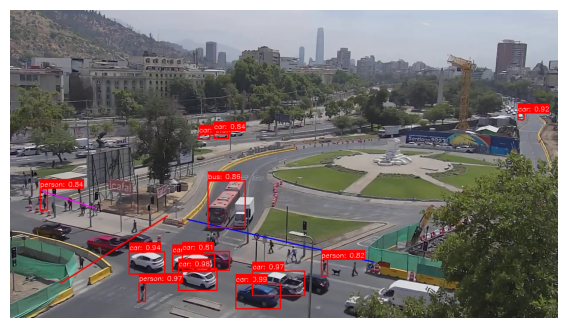

In [22]:
# make prediction and plot
image_path = 'frame.jpg'
image, boxes, labels, scores = detector.detect(image_path)
plot_predicted(image, boxes, labels, scores)